In [1]:
import subprocess
_output = subprocess.check_output(["maturin", "develop"])

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/wint3rmute/code/luthier/.venv/bin/python
📡 Using build options features from pyproject.toml
   --> src/ladder_filter.rs:131:8
    |
110 | impl LadderFilter {
    | ----------------- method in this implementation
...
131 |     fn run_ladder_nonlinear(&mut self, input: f64) {
    |        ^^^^^^^^^^^^^^^^^^^^
    |
    = note: `#[warn(dead_code)]` on by default

    Finished dev [unoptimized + debuginfo] target(s) in 0.04s
⚠️ Warning: Failed to set rpath for /home/wint3rmute/code/luthier/target/debug/libluthier.so: Failed to execute 'patchelf', did you install it? Hint: Try `pip install maturin[patchelf]` (or just `pip install patchelf`)
📦 Built wheel for CPython 3.10 to /tmp/.tmpnpdOZD/luthier-0.1.0-cp310-cp310-linux_x86_64.whl
🛠 Installed luthier-0.1.0


In [2]:
from luthier.luthier import DspGraph, SineOscillator, Multiplier, HarmonicMultiplier, Sum, ADSR, SquareOscillator, LowPassFilter, Reverb
from IPython.display import Audio, display, Image, HTML
from luthier.dsp import Sample, SAMPLE_RATE
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm.notebook import tqdm
import librosa
from scipy.optimize import differential_evolution
import numpy as np
from IPython.display import clear_output

# Sound engine presentation

- Talk about nodes
- Talk about connections (modulation)
- Outine the idea behind FM synthesis:
    - Modulation
    - Harmonics

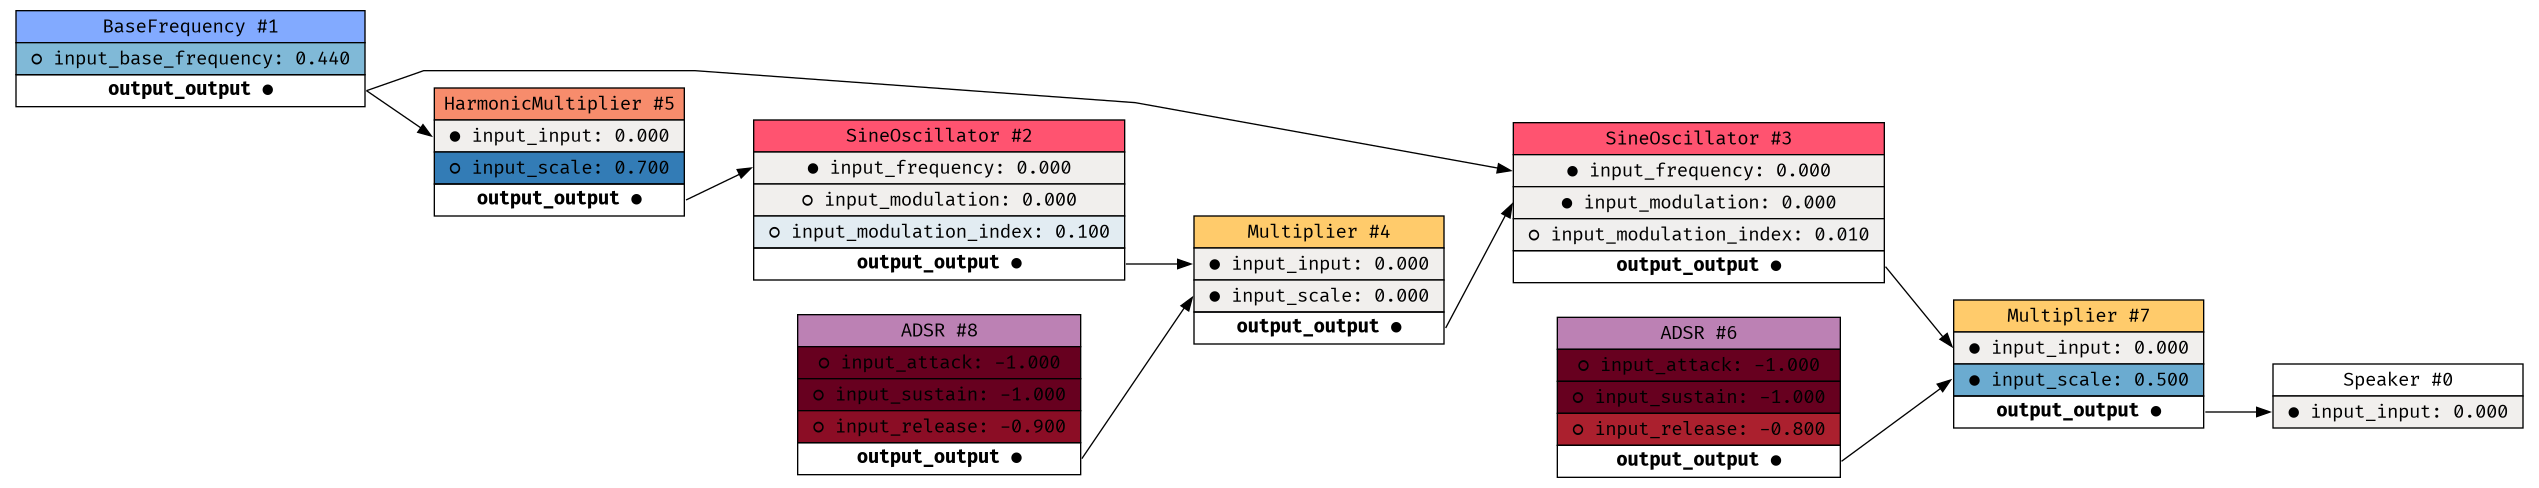

10

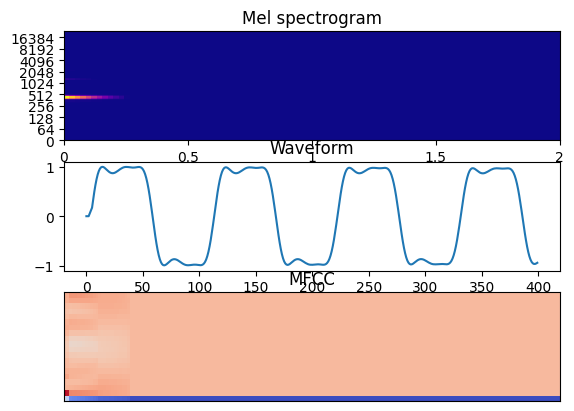

In [3]:
def one_operator_fm():
    graph = DspGraph()
    modulator = graph.add_sine(SineOscillator())
    _carrier = SineOscillator()
    carrier = graph.add_sine(_carrier)
    
    mod_index_scaler = graph.add_multiplier(Multiplier())
    mod_freq_mult = graph.add_harmonic_multiplier(HarmonicMultiplier())
    amp_adsr = graph.add_adsr(ADSR())
    amp_apply = graph.add_multiplier(Multiplier())
    
    mod_adsr = graph.add_adsr(ADSR())
    graph.patch(mod_adsr, "output_output", mod_index_scaler, "input_scale")
    
    # mod_adsr = graph.add_adsr(ADSR())
    # graph.patch(mod_adsr, "output_output", mod_index_scaler, "input_scale")
    graph.patch(amp_apply, "output_output", graph.speaker_node_id, "input_input")
    graph.patch(amp_adsr, "output_output", amp_apply, "input_scale")
    # graph.patch(
    
    graph.patch(carrier, "output_output", amp_apply, "input_input")
    graph.patch(graph.base_frequency_node_id, "output_output", carrier, "input_frequency")
    graph.patch(graph.base_frequency_node_id, "output_output", mod_freq_mult, "input_input" )
    graph.patch(mod_freq_mult, "output_output", modulator, "input_frequency")
    graph.patch(modulator, "output_output", mod_index_scaler, "input_input")
    graph.patch(mod_index_scaler, "output_output", carrier, "input_modulation")
    
    graph.set_input(4, "input_scale", 0.0 ) # mod index
    
    # graph.set_input(5, "input_scale", -0.3)
    # graph.set_input(5, "input_scale", 0.3)
    graph.set_input(5, "input_scale", 0.7)
    
    graph.set_input(3, "input_modulation_index", 0.01)

    graph.set_input(6, "input_attack", -1.0)
    graph.set_input(6, "input_sustain", -1.0)
    graph.set_input(6, "input_release", -0.8)
    
    graph.set_input(8, "input_attack", -1.0)
    graph.set_input(8, "input_sustain", -1.0)
    graph.set_input(8, "input_release", -0.9)
    
    return graph

target_graph = one_operator_fm()
display(Image(target_graph.draw()))
target_audio = Sample(target_graph.play(num_samples = SAMPLE_RATE*2))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, sharey=False)
target_audio.plot_spectrogram(ax1)
target_audio.plot_waveform(ax2)
target_audio.plot_mfcc(ax3)
target_audio.show_player()
target_graph.num_inputs()

In [4]:
# librosa.feature.rms(y=target_audio.buffer)[0]
# sum(target_audio.mfcc) * librosa.feature.rms(y=target_audio.buffer)

# Loss function

- Describe what MFCC is and how it relates to the Fourier Transform
- Show how MFCC varies depending on the different parameter values

  0%|          | 0/201 [00:00<?, ?it/s]

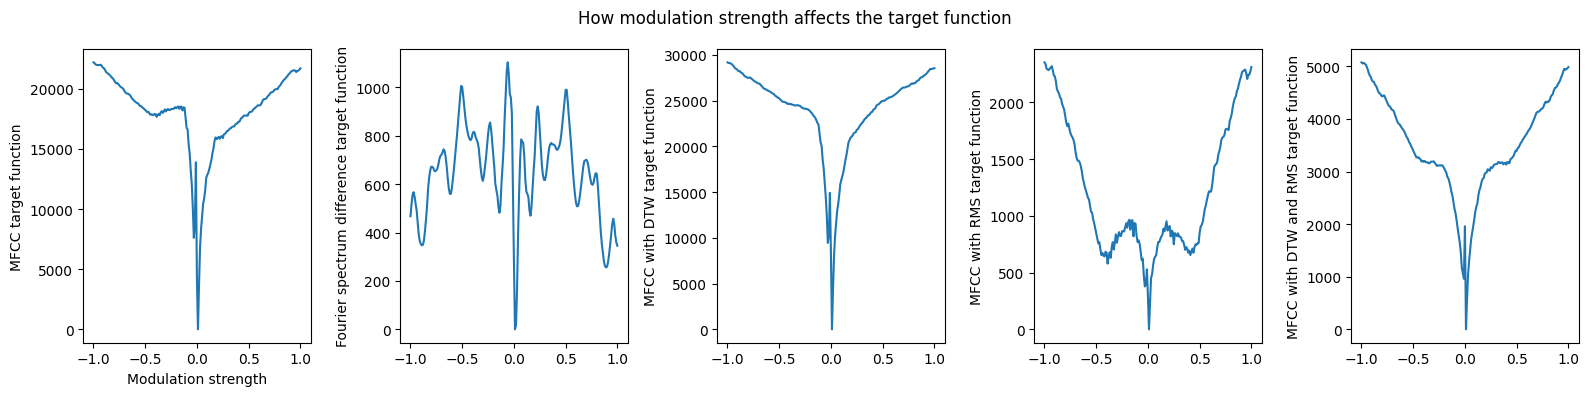

In [5]:
mod_strengths = [ a / 100 for a in range(-100, 101, 1)]

def get_distance_variable_mod_strength(strength):
    graph = one_operator_fm()
    graph.set_input(3, "input_modulation_index", strength)
    generated_audio = Sample(graph.play(len(target_audio)))
    mfcc_dist = target_audio.mfcc_distance(generated_audio)
    mfcc_dist_dtw = target_audio.mfcc_distance_with_dtw(generated_audio)
    spectrogram_dist = target_audio.spectrogram_distance(generated_audio)
    mfcc_dist_rms = target_audio.mfcc_distance_with_rms(generated_audio)
    mfcc_dist_dtw_rms = target_audio.mfcc_distance_with_dtw_and_rms(generated_audio)
    return mfcc_dist, spectrogram_dist, mfcc_dist_dtw, mfcc_dist_rms, mfcc_dist_dtw_rms

with Pool() as p:
    results = list(tqdm(p.imap(get_distance_variable_mod_strength, mod_strengths), total=len(mod_strengths)))

mfcc_results = [r[0] for r in results]
spectrogram_results = [r[1] for r in results]
mfcc_dtw_results = [r[2] for r in results]
mfcc_rms_results = [r[3] for r in results]
mfcc_dtw_rms_results = [r[4] for r in results]

plt.rcParams.update({'figure.figsize': (16,4)})
fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5)
fig.suptitle("How modulation strength affects the target function")
ax1.plot(mod_strengths, mfcc_results)
ax2.plot(mod_strengths, spectrogram_results)
ax3.plot(mod_strengths, mfcc_dtw_results)
ax4.plot(mod_strengths, mfcc_rms_results)
ax5.plot(mod_strengths, mfcc_dtw_rms_results)
ax1.set_xlabel("Modulation strength")
ax1.set_ylabel("MFCC target function")
ax2.set_ylabel("Fourier spectrum difference target function")
ax3.set_ylabel("MFCC with DTW target function")
ax4.set_ylabel("MFCC with RMS target function")
ax5.set_ylabel("MFCC with DTW and RMS target function")

fig.tight_layout()
plt.show()

In [6]:
# _, spec = target_audio.spectrogram

target_audio.spectrogram_distance(target_audio)

0.0

  0%|          | 0/20 [00:00<?, ?it/s]

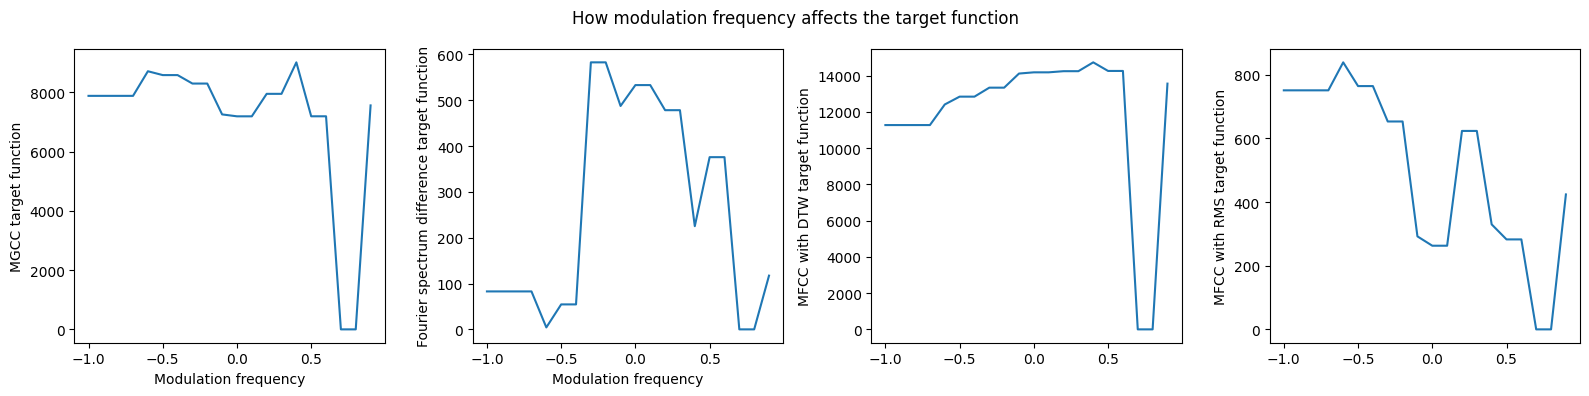

In [7]:
mod_freqs = [ a / 100 for a in range(-100, 100, 10) ]
results = []

def get_distance_variable_mod_freq(freq):
    graph = one_operator_fm()
    graph.set_input(5, "input_scale", freq)
    # graph.set_input(5, "input_scale", 1.0)
    generated_audio = Sample(graph.play(len(target_audio)))
    mfcc_dist = target_audio.mfcc_distance(generated_audio)
    mfcc_dist_dtw = target_audio.mfcc_distance_with_dtw(generated_audio)
    spectrogram_dist = target_audio.spectrogram_distance(generated_audio)
    mfcc_dist_rms = target_audio.mfcc_distance_with_rms(generated_audio)
    return mfcc_dist, spectrogram_dist, mfcc_dist_dtw, mfcc_dist_rms

with Pool() as p:
    results = list(tqdm(p.imap(get_distance_variable_mod_freq, mod_freqs), total=len(mod_freqs)))

mfcc_results = [r[0] for r in results]
spectrogram_results = [r[1] for r in results]
mfcc_dtw_results = [r[2] for r in results]
mfcc_rms_results = [r[3] for r in results]

plt.rcParams.update({'figure.figsize': (16,4)})
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4)
ax1.plot(mod_freqs, mfcc_results)
ax2.plot(mod_freqs, spectrogram_results)
ax3.plot(mod_freqs, mfcc_dtw_results)
ax4.plot(mod_freqs, mfcc_rms_results)

ax1.set_xlabel("Modulation frequency")
ax1.set_ylabel("MGCC target function")
ax2.set_xlabel("Modulation frequency")
ax2.set_ylabel("Fourier spectrum difference target function")

ax3.set_ylabel("MFCC with DTW target function")
ax4.set_ylabel("MFCC with RMS target function")

fig.suptitle("How modulation frequency affects the target function")
fig.tight_layout()
plt.show()

  0%|          | 0/67 [00:00<?, ?it/s]

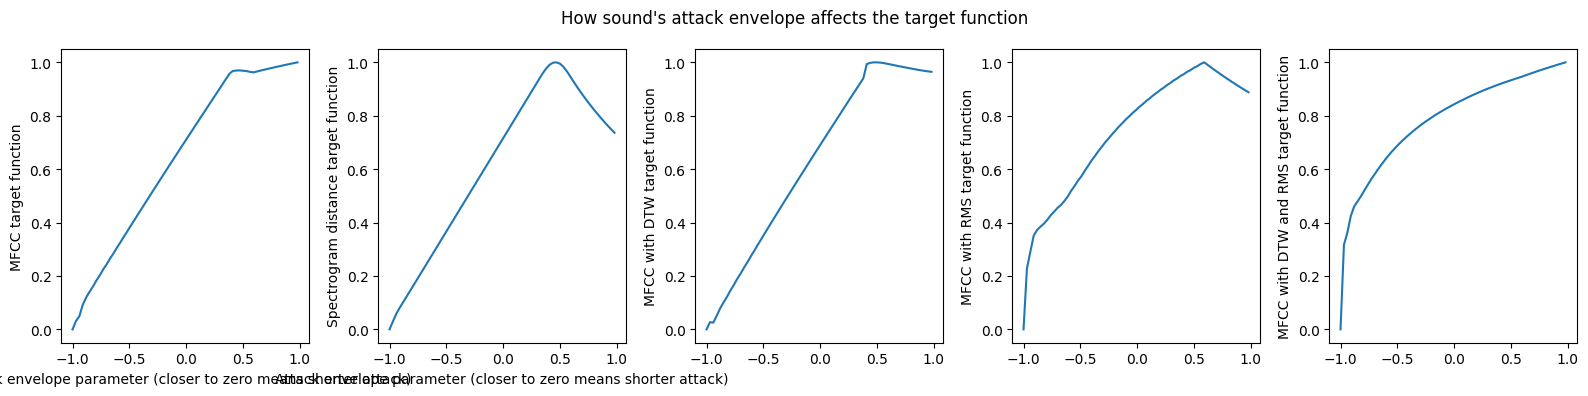

In [8]:
attack_values = [ a / 100 for a in range(-100, 100, 3) ]
results = []

def get_distance_variable_attack(attack):
    graph = one_operator_fm()
    graph.set_input(6, "input_attack", attack)
    generated_audio = Sample(graph.play(len(target_audio)))
    # dist = frechet.calculate_frechet_distance(target_audio.buffer, gene
    # rated_audio.buffer, 0.1, 0.1)

    mfcc_dist = target_audio.mfcc_distance(generated_audio)
    mfcc_dist_dtw = target_audio.mfcc_distance_with_dtw(generated_audio)
    spectrogram_dist = target_audio.spectrogram_distance(generated_audio)
    mfcc_dist_rms = target_audio.mfcc_distance_with_rms(generated_audio)
    mfcc_dist_dtw_rms = target_audio.mfcc_distance_with_dtw_and_rms(generated_audio)
    return mfcc_dist, spectrogram_dist, mfcc_dist_dtw, mfcc_dist_rms, mfcc_dist_dtw_rms

with Pool() as p:
    results = list(tqdm(p.imap(get_distance_variable_attack, attack_values), total=len(attack_values)))

mfcc_results = np.array([r[0] for r in results])
spectrogram_results = np.array([r[1] for r in results])
mfcc_dtw_results = np.array([r[2] for r in results])
mfcc_rms_results = np.array([r[3] for r in results])
mfcc_dtw_rms_results = np.array([r[4] for r in results])

mfcc_results /= max(mfcc_results)
spectrogram_results /= max(spectrogram_results)
mfcc_dtw_results /= max(mfcc_dtw_results)
mfcc_rms_results /= max(mfcc_rms_results)
mfcc_dtw_rms_results /= max(mfcc_dtw_rms_results)
    

plt.rcParams.update({'figure.figsize': (16,4)})
fig, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(1, 5)
ax1.plot(attack_values, mfcc_results)
ax2.plot(attack_values, spectrogram_results)
ax3.plot(attack_values, mfcc_dtw_results)
ax4.plot(attack_values, mfcc_rms_results)
ax5.plot(attack_values, mfcc_dtw_rms_results)
ax1.set_xlabel("Attack envelope parameter (closer to zero means shorter attack)")
ax1.set_ylabel("MFCC target function")
ax2.set_xlabel("Attack envelope parameter (closer to zero means shorter attack)")
ax2.set_ylabel("Spectrogram distance target function")
ax3.set_ylabel("MFCC with DTW target function")
ax4.set_ylabel("MFCC with RMS target function")
ax5.set_ylabel("MFCC with DTW and RMS target function")

ax3.set_ylabel("MFCC with DTW target function")
fig.suptitle("How sound's attack envelope affects the target function")
plt.tight_layout()
# plt.plot(attack_values, results)
# plt.xlabel("Attack envelope parameter (closer to zero means shorter attack)")
# plt.ylabel("Target function")
plt.show()

  0%|          | 0/121 [00:00<?, ?it/s]

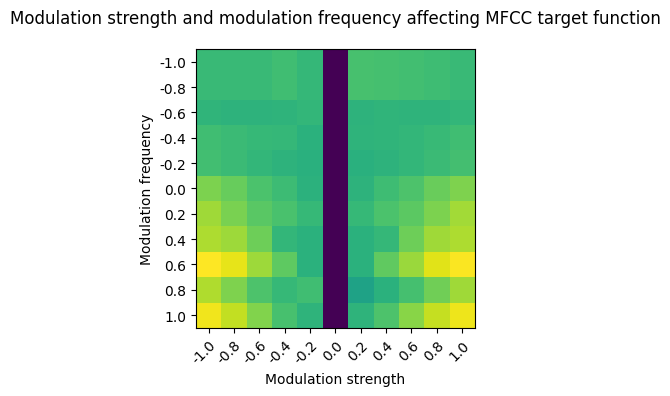

In [9]:
STEP_VALUE = 20 # Lower means better resolution
mod_freqs = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 
mod_strengths = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 

test_cases = []
for freq_index, freq in enumerate(mod_freqs):
    for mod_index, mod_strength in enumerate(mod_strengths):    
        test_cases.append( ( (freq_index, freq), (mod_index, mod_strength) ) )

def get_distance_variable_mod_strength(test_case):
    (freq_index, freq), (mod_index, mod_strength) = test_case
    graph = one_operator_fm()

    graph.set_input(5, "input_scale", freq)
    graph.set_input(3, "input_modulation_index", mod_strength)
    generated_audio = Sample(graph.play(len(target_audio)))

    dist = target_audio.mfcc_distance(generated_audio)
    
    return freq_index, mod_index, dist
    
with Pool() as p:
    pool_results = list(tqdm(p.imap(get_distance_variable_mod_strength, test_cases), total=len(test_cases)))  
    
results = np.zeros((len(mod_freqs), len(mod_strengths)))

for pool_result in pool_results:
    freq_index, mod_index, dist = pool_result
    results[freq_index][mod_index] = dist
    
fig, ax = plt.subplots()
im = ax.imshow(results)

ax.set_xticks(np.arange(len(mod_strengths)), labels=mod_strengths)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_yticks(np.arange(len(mod_freqs)), labels=mod_freqs)
ax.set_ylabel("Modulation frequency")
ax.set_xlabel("Modulation strength")
fig.suptitle("Modulation strength and modulation frequency affecting MFCC target function")
fig.tight_layout()

  0%|          | 0/121 [00:00<?, ?it/s]

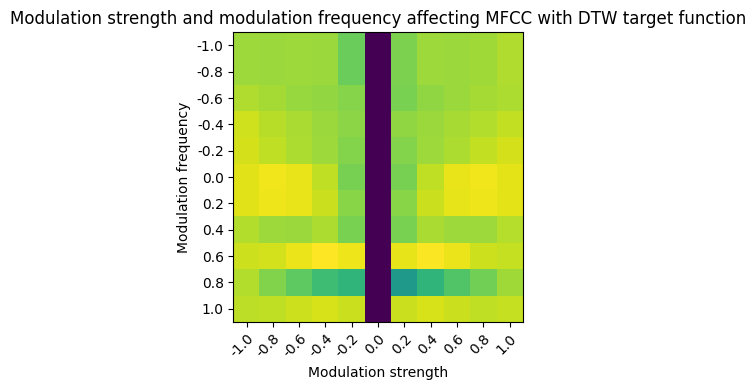

In [10]:
STEP_VALUE = 20 # Lower means better resolution
mod_freqs = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 
mod_strengths = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 

test_cases = []
for freq_index, freq in enumerate(mod_freqs):
    for mod_index, mod_strength in enumerate(mod_strengths):    
        test_cases.append( ( (freq_index, freq), (mod_index, mod_strength) ) )

def get_distance_variable_mod_strength(test_case):
    (freq_index, freq), (mod_index, mod_strength) = test_case
    graph = one_operator_fm()

    graph.set_input(5, "input_scale", freq)
    graph.set_input(3, "input_modulation_index", mod_strength)
    generated_audio = Sample(graph.play(len(target_audio)))

    dist = target_audio.mfcc_distance_with_dtw(generated_audio)
    
    return freq_index, mod_index, dist
    
with Pool() as p:
    pool_results = list(tqdm(p.imap(get_distance_variable_mod_strength, test_cases), total=len(test_cases)))  
    
results = np.zeros((len(mod_freqs), len(mod_strengths)))

for pool_result in pool_results:
    freq_index, mod_index, dist = pool_result
    results[freq_index][mod_index] = dist
    
fig, ax = plt.subplots()
im = ax.imshow(results)

ax.set_xticks(np.arange(len(mod_strengths)), labels=mod_strengths)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_yticks(np.arange(len(mod_freqs)), labels=mod_freqs)
ax.set_ylabel("Modulation frequency")
ax.set_xlabel("Modulation strength")
plt.title("Modulation strength and modulation frequency affecting MFCC with DTW target function")
fig.tight_layout()

  0%|          | 0/121 [00:00<?, ?it/s]

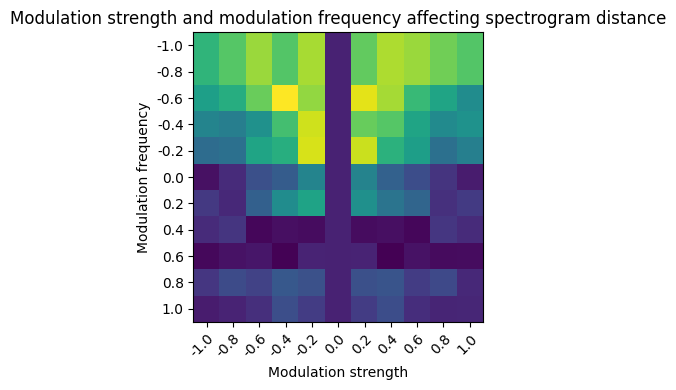

In [11]:
STEP_VALUE = 20 # Lower means better resolution
mod_freqs = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 
mod_strengths = [ a / 100 for a in range(-100, 101, STEP_VALUE) ] 

test_cases = []
for freq_index, freq in enumerate(mod_freqs):
    for mod_index, mod_strength in enumerate(mod_strengths):    
        test_cases.append( ( (freq_index, freq), (mod_index, mod_strength) ) )

def get_distance_variable_mod_strength(test_case):
    (freq_index, freq), (mod_index, mod_strength) = test_case
    graph = one_operator_fm()

    graph.set_input(5, "input_scale", freq)
    graph.set_input(3, "input_modulation_index", mod_strength)
    generated_audio = Sample(graph.play(len(target_audio)))

    dist = target_audio.spectrogram_distance(generated_audio)
    
    return freq_index, mod_index, dist
    
with Pool() as p:
    pool_results = list(tqdm(p.imap(get_distance_variable_mod_strength, test_cases), total=len(test_cases)))  
    
results = np.zeros((len(mod_freqs), len(mod_strengths)))

for pool_result in pool_results:
    freq_index, mod_index, dist = pool_result
    results[freq_index][mod_index] = dist
    
fig, ax = plt.subplots()
im = ax.imshow(results)

ax.set_xticks(np.arange(len(mod_strengths)), labels=mod_strengths)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_yticks(np.arange(len(mod_freqs)), labels=mod_freqs)
ax.set_ylabel("Modulation frequency")
ax.set_xlabel("Modulation strength")
plt.title("Modulation strength and modulation frequency affecting spectrogram distance")
fig.tight_layout()

In [12]:
generated_sound

NameError: name 'generated_sound' is not defined